In [25]:

import pandas as pd
import re
from tqdm import tqdm
from langchain.vectorstores.faiss import FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


In [6]:
## clean and process so

def cleanhtml(raw_html):
    CLEANR = re.compile('<.*?>')
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext
    
def clean_data(df):
    df["pt_answer"] = df["pt_answer"].apply(lambda x: cleanhtml(x))

    df["question"] = df["pt_title"].str.lower()
    df["answer"] = df["pt_answer"].str.lower()

    df = df[['pt_post_id','question', 'answer']]
    return df
    

## get qa and link to post
def get_url(df):
    url = []
    for index, row in df.iterrows():
        url.append(f"https://stackoverflow.com/questions/{row['pt_post_id']}/")
    
    df['source'] = url

    return df

df = pd.read_csv('pt_question_answers_updated.csv')
df = clean_data(df)
df = get_url(df)
df = df[['question','answer','source']]

## create faiss index to fetch nearest docs and create context column

In [23]:
def split_pages(df):
    splitter = CharacterTextSplitter(separator="\n", chunk_size=2048)
    print('chunking pages into smaller sub-pages')
            
    pages = []

    for index, i in df.iterrows():
        texts = "QUESTION: " + i['question'] + "\nANSWER: " + i['answer']
        meta = {'source':i['source']}
        pages.extend(splitter.create_documents([texts], [meta]))
    pickle.dump(pages, open('so_pages.pkl', 'wb'))

In [24]:
split_pages(df)

Created a chunk of size 2710, which is longer than the specified 2048


chunking pages into smaller sub-pages


Created a chunk of size 8837, which is longer than the specified 2048
Created a chunk of size 2105, which is longer than the specified 2048
Created a chunk of size 2466, which is longer than the specified 2048
Created a chunk of size 2467, which is longer than the specified 2048


In [69]:
pages = pickle.load(open('so_pages.pkl', 'rb'))

EMBED = "hf"
embeddings = HuggingFaceEmbeddings()

docsearch = FAISS.from_documents([pages.pop(0)], embeddings)
i, step = 0, 50
while i<len(pages):
    if i%500==0:
        print(i,'pages done')
    texts = [d.page_content for d in pages[i:i+step]]
    meta = [d.metadata for d in pages[i:i+step]]
    docsearch.add_texts(texts, meta)
    i += step
print(len(pages),'pages done')

0 pages done
500 pages done
1000 pages done
1500 pages done
2000 pages done
2500 pages done
3000 pages done
3500 pages done
4000 pages done
4500 pages done
5000 pages done
5500 pages done
6000 pages done
6500 pages done
7000 pages done
7500 pages done
8000 pages done
8500 pages done
9000 pages done
9500 pages done
10000 pages done
10500 pages done
11000 pages done
11500 pages done
12000 pages done
12002 pages done


## query nearest 2 docs and create new column context

In [13]:

docsearch = FAISS.load_local("so_faiss_index", embeddings)
context = []

for index, i in tqdm(df.iterrows(),total=len(df)):
    docs = docsearch.similarity_search_with_score(i['question'], k = 2)
    ans = []
    for doc in docs:
        text = doc[0].page_content.split('ANSWER:')[-1].lstrip()
        ans.append("Answer: " + doc[0].page_content.split('ANSWER:')[-1])
    for item in ans:
        if i['answer'][:20] in item:
            pass
        else:
            ans[0] = 'Answer: ' + i['answer']
    context.append(', '.join(ans))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10763/10763 [03:38<00:00, 49.33it/s]


In [14]:
df['context'] = context

In [15]:
df

,question,answer,source,context
0,extracting the top-k value-indices from a 1-d ...,as of pull request #496 torch now includes a b...,https://stackoverflow.com/questions/34750268/,Answer: as of pull request #496 torch now incl...
1,how to display custom images in tensorboard (e...,it is quite easy to do if you have the image i...,https://stackoverflow.com/questions/38543850/,Answer: it is quite easy to do if you have the...
2,python wheels: cp27mu not supported,this is exactly that. \nrecompile python under...,https://stackoverflow.com/questions/41767005/,Answer: this is exactly that. \nrecompile pyth...
3,loading torch7 trained models (.t7) in pytorch,as of pytorch 1.0 torch.utils.serialization is...,https://stackoverflow.com/questions/41861354/,Answer: as of pytorch 1.0 torch.utils.serializ...
4,pytorch: how to use dataloaders for custom dat...,"yes, that is possible. just create the objects...",https://stackoverflow.com/questions/41924453/,"Answer: yes, that is possible. just create the..."
...,...,...,...,...
10758,is it possible to perform quantization on dens...,here's how to do this on densenet169 from torc...,https://stackoverflow.com/questions/74612146/,Answer: here's how to do this on densenet169 f...
10759,"why when the batch size increased, the epoch t...","as you already noticed, there are many factors...",https://stackoverflow.com/questions/74637151/,"Answer: as you already noticed, there are many..."
10760,why does stablediffusionpipeline return black ...,apparently it is indeed an apple silicon (m1/m...,https://stackoverflow.com/questions/74642594/,Answer: apparently it is indeed an apple silic...
10761,locating tags in a string in php (with respect...,i think i've got something. how about this:\nf...,https://stackoverflow.com/questions/74671399/,Answer: i think i've got something. how about ...


In [68]:
df.to_csv('so_data_with_context.csv')

## using openai summarize this context

In [36]:

import concurrent.futures
import requests
import openai

api_key = ''

def get_qa_openai(context, index):
    try:
        completion = openai.ChatCompletion.create(
                model="gpt-3.5-turbo", api_key = api_key,
                messages=[
                    {"role": "user", "content": context}
                  ]
                )

        qa = completion.choices[0].message.content

    except requests.exceptions.RequestException as e:
        print(f'Request failed with error: {str(e)}.')
        print(f'Waiting for 3 minutes before trying again...')
        time.sleep(180)
    
    return (qa, index)

questions_ans = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    
    futures = []
    for index,i in df.iterrows():

        context = f"Reduce the context size as much as you can in the following context but preserve the code and important details that answers the question: \
                    question: {i['question']}, context:{i['context']}"
        
        futures.append(executor.submit(get_qa_openai, context, index))

    for future, (_, row) in tqdm(zip(concurrent.futures.as_completed(futures), df.iterrows()), total=len(df)):
        try:
            qa, ind = future.result()
            questions_ans.append((ind,qa))
        except Exception as exc:
            print(f'generated an exception: {exc}')

  1%|▍                                    | 136/10763 [01:04<1:26:54,  2.04it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 6b59b291b4d8a159e8c619acf0899f4f in your message.)


  2%|▋                                      | 201/10763 [01:30<46:14,  3.81it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e5db53fd7c0b1cd8847304a043be7378 in your message.)


  3%|▉                                      | 273/10763 [02:00<57:07,  3.06it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 872199c0c291f2514e9426c9cfb6a0a0 in your message.)


  4%|█▌                                   | 451/10763 [03:24<1:16:54,  2.23it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 5e9b7dd24a60cc2335b70d47ccbfd357 in your message.)


  6%|██▏                                  | 621/10763 [04:47<1:56:51,  1.45it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7e23c5058b3c7a85f940df6f7188a141 in your message.)


 11%|████                                  | 1159/10763 [08:57<37:19,  4.29it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 0d787eb49f9ce4a72de4d380fc3f747c in your message.)


 11%|███▉                                | 1176/10763 [09:06<1:03:23,  2.52it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 195e81baa2f42a92a8f34fcaffdcad4f in your message.)


 17%|██████▏                             | 1856/10763 [14:42<2:56:50,  1.19s/it]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2c23000f08a08d9442df135e5c8d9d2d in your message.)


 20%|███████▍                              | 2108/10763 [16:38<47:11,  3.06it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID ce74677ef317bbf1ed991e5e56e96c4d in your message.)


 21%|███████▌                            | 2253/10763 [17:45<1:03:43,  2.23it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 78e1dc65c4e087b4d1d05a5d5b1b1ad9 in your message.)


 21%|████████                              | 2273/10763 [17:53<58:49,  2.41it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d7de039dd4b4079bcecdd5a6aa18a7c8 in your message.)


 21%|███████▋                            | 2304/10763 [18:11<1:19:38,  1.77it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 5e86e09084f6e809f4c8ab41510882a0 in your message.)


 22%|███████▊                            | 2321/10763 [18:20<1:38:49,  1.42it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7588031b5b74ee202a7748536f74c631 in your message.)


 22%|████████▏                             | 2334/10763 [18:25<37:55,  3.70it/s]

generated an exception: This model's maximum context length is 4097 tokens. However, your messages resulted in 4450 tokens. Please reduce the length of the messages.


 22%|███████▉                            | 2366/10763 [18:40<1:24:19,  1.66it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 6e472e2c07c8bbf108800f5ac3287484 in your message.)


 22%|████████▍                             | 2385/10763 [18:50<56:42,  2.46it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 1a499f7c8f51292d78c156df8befc11c in your message.)


 24%|████████▋                           | 2603/10763 [20:49<1:04:44,  2.10it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e8e6ced00e1c018b6f6cda46f4a3aac6 in your message.)


 25%|█████████▎                            | 2654/10763 [21:11<43:59,  3.07it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID b6e51cf56d00f41c1815e3a6ae10022c in your message.)


 26%|█████████▎                          | 2771/10763 [22:09<1:01:40,  2.16it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 45d79cdf9a0bd806ab7c685379db1adb in your message.)


 26%|█████████▍                          | 2830/10763 [22:39<1:22:52,  1.60it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d51dea0bc40cc25ee49e60cb9381935a in your message.)


 26%|██████████                            | 2849/10763 [22:48<50:35,  2.61it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 34ddd5e6e49a2e16d5078def3b01140e in your message.)


 27%|██████████                            | 2865/10763 [22:56<47:35,  2.77it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID ff1e64c70f37ac393fdae180cdc9a8e3 in your message.)


 27%|█████████▊                          | 2937/10763 [23:28<1:28:02,  1.48it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 9d50385729c2655da2b77a74657c23f9 in your message.)


 27%|██████████▍                           | 2942/10763 [23:30<56:23,  2.31it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:43:25 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8da9855a06ec1b-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 27%|██████████▍                           | 2945/10763 [23:31<35:17,  3.69it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:43:26 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8da97aac53c729-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 27%|██████████▍                           | 2946/10763 [23:31<42:14,  3.08it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:43:26 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8da99d380c283b-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 27%|█████████▊                          | 2951/10763 [23:33<1:00:39,  2.15it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:43:28 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8da9a7dbe7283b-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 27%|██████████▍                           | 2953/10763 [23:34<58:12,  2.24it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:43:29 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8da99aba91c361-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 28%|██████████▌                           | 2981/10763 [23:48<53:42,  2.42it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:43:43 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8da9f5cd6ec4a5-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 28%|██████████▊                           | 3048/10763 [24:22<48:18,  2.66it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:17 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daa238e89c551-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 28%|██████████▊                           | 3051/10763 [24:23<38:36,  3.33it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:18 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daae8691aec0f-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 28%|██████████▊                           | 3058/10763 [24:25<31:15,  4.11it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:20 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daaaffdf6c4a0-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:20 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 28%|██████████▊                           | 3061/10763 [24:25<21:41,  5.92it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:20 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daabf0b67092f-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 28%|██████████▊                           | 3065/10763 [24:25<20:09,  6.37it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:20 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daaf668eac4a0-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:21 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 28%|██████████▊                           | 3066/10763 [24:26<19:55,  6.44it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:21 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daaf9deacec70-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:21 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3082/10763 [24:32<42:08,  3.04it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:27 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daafede0bc38f-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:27 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3086/10763 [24:34<46:09,  2.77it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:29 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daaf80bf6092f-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 29%|██████████▉                           | 3092/10763 [24:34<24:59,  5.12it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:30 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daaef5aedc361-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:30 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3095/10763 [24:35<25:02,  5.10it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:30 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daad15c3bc729-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:30 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3099/10763 [24:35<17:08,  7.45it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:30 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab33be51c4bb-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:31 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3103/10763 [24:36<17:51,  7.15it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:31 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daae8ded8c4de-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:31 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3109/10763 [24:37<11:35, 11.00it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:32 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab3d9c51ec98-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:32 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3111/10763 [24:37<22:06,  5.77it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:33 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab34bb39c38f-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:33 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3113/10763 [24:38<20:16,  6.29it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:33 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab4178cdec98-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:33 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|██████████▉                           | 3115/10763 [24:38<18:37,  6.84it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:33 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daafb1dcec4a0-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 29%|███████████                           | 3117/10763 [24:38<22:55,  5.56it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:33 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab480862ec98-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:34 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|███████████                           | 3121/10763 [24:39<18:08,  7.02it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:34 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8daafd4b43ec70-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:34 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|███████████                           | 3122/10763 [24:39<18:46,  6.78it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:34 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab339fdac361-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 29%|███████████                           | 3123/10763 [24:39<21:47,  5.85it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:34 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab340e15c551-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:34 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|███████████                           | 3128/10763 [24:40<14:26,  8.81it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:35 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab178e9908a1-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:35 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|███████████                           | 3133/10763 [24:40<09:29, 13.41it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:35 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab4ccc9dec0f-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:35 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|███████████                           | 3139/10763 [24:40<08:13, 15.44it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:35 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab5049cec361-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:35 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|███████████                           | 3143/10763 [24:41<09:14, 13.75it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab39fa5230b1-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 29%|███████████                           | 3147/10763 [24:41<15:08,  8.38it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dab2b8b8dec64-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}
generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:44:36 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 

 31%|███████████▋                          | 3327/10763 [26:16<49:09,  2.52it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID b26451777655c4886cbc01fc6d58f182 in your message.)


 31%|███████████▊                          | 3340/10763 [26:20<32:01,  3.86it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 56e799d5ca1edf600a76332c01a1d465 in your message.)


 33%|████████████▍                         | 3521/10763 [27:45<43:33,  2.77it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID a768b1acd1fc1690e6f871cecbd525d4 in your message.)


 33%|████████████▌                         | 3568/10763 [28:07<54:32,  2.20it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c91c23ae1ceceff8bc7122648e8695fe in your message.)


 33%|████████████▋                         | 3603/10763 [28:23<47:21,  2.52it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 07f46befc7b91f7f5f95d0591a29250f in your message.)


 35%|████████████▍                       | 3717/10763 [29:14<1:17:50,  1.51it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 3a5fc5e6a1523529ca13698571913abd in your message.)


 35%|████████████▌                       | 3753/10763 [29:32<1:04:43,  1.80it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 512f16841352446c03ed75a5441fed4c in your message.)


 36%|█████████████▌                        | 3830/10763 [30:11<54:36,  2.12it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 6f1f09ba8e084c10123c1e51b7acbedc in your message.)


 36%|████████████▊                       | 3834/10763 [30:14<1:04:02,  1.80it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4b6cd91de975c9d6ab1e62c27abf2ab9 in your message.)


 37%|█████████████▉                        | 3961/10763 [31:14<50:17,  2.25it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 9dc455232fe1518e4b21cc3eca0b0b07 in your message.)


 37%|██████████████▏                       | 4015/10763 [31:42<33:02,  3.40it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4496b5c14a79dd58aed9748ccf7c8468 in your message.)


 39%|██████████████                      | 4193/10763 [33:10<1:10:04,  1.56it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID a7e615f7adc22f88ab38dc94d1b9e2f4 in your message.)


 40%|██████████████▏                     | 4257/10763 [33:43<1:29:48,  1.21it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d862db659be6cab8c45e52319b52076b in your message.)


 40%|██████████████▍                     | 4300/10763 [34:06<1:08:54,  1.56it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 1a1b55953d1ce20c70a0bd8c3ff23451 in your message.)


 40%|███████████████▎                      | 4329/10763 [34:20<35:37,  3.01it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 02bb2e3836a8cf274275e207a4a256d7 in your message.)


 40%|███████████████▎                      | 4334/10763 [34:22<30:51,  3.47it/s]

generated an exception: This model's maximum context length is 4097 tokens. However, your messages resulted in 4257 tokens. Please reduce the length of the messages.


 40%|███████████████▎                      | 4338/10763 [34:23<26:05,  4.10it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID a0d7a41f69569a03f72417f23fe47ee3 in your message.)


 42%|███████████████▉                      | 4507/10763 [35:46<20:15,  5.15it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4b94efa5b311fee262ae8cb658501298 in your message.)


 43%|███████████████▎                    | 4592/10763 [36:23<1:14:29,  1.38it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:56:19 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8db4a97b44c678-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 43%|████████████████▍                     | 4645/10763 [36:45<35:51,  2.84it/s]

generated an exception: This model's maximum context length is 4097 tokens. However, your messages resulted in 4684 tokens. Please reduce the length of the messages.


 43%|████████████████▍                     | 4654/10763 [36:49<41:40,  2.44it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d98e16555f4a313a4e26040886e2520b in your message.)


 43%|███████████████▌                    | 4661/10763 [36:54<1:40:34,  1.01it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d6205d550b88b2e0b138ba4c179cddb0 in your message.)


 44%|███████████████▊                    | 4738/10763 [37:37<1:22:17,  1.22it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e22588c303a73761732af674b099b3ce in your message.)


 44%|███████████████▉                    | 4774/10763 [37:54<1:16:03,  1.31it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 81e7fcd38dd8daa5268bcdec1edee654 in your message.)


 46%|█████████████████▌                    | 4978/10763 [39:33<41:33,  2.32it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 17:59:28 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8db947b8fc30ac-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 51%|███████████████████▏                  | 5451/10763 [43:16<48:27,  1.83it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 8782225b940d99289cec66cf13a7be6b in your message.)


 52%|███████████████████▋                  | 5579/10763 [44:14<46:20,  1.86it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2d3e064d8d9ddb72dd2fcb010f8836ff in your message.)


 53%|████████████████████▏                 | 5729/10763 [45:26<43:19,  1.94it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 1daf981a46a89b58d7e4d621ef9d43c3 in your message.)


 54%|████████████████████▍                 | 5790/10763 [45:49<24:08,  3.43it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4e16ac48d6ee6c22955935ee2b97d9e1 in your message.)


 55%|████████████████████▉                 | 5937/10763 [46:54<43:42,  1.84it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c52e82a620d5c8b921e4c6b908613ca0 in your message.)


 57%|█████████████████████▋                | 6152/10763 [48:37<28:02,  2.74it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 8f90614b9e8b93151c13c252a890e66c in your message.)


 58%|█████████████████████▊                | 6192/10763 [49:00<38:22,  1.98it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 14ba00b7276069d88677e933bbf2c78d in your message.)


 59%|██████████████████████▎               | 6325/10763 [49:55<31:19,  2.36it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d090b3c7378d03b38785b628cf7279af in your message.)


 59%|██████████████████████▌               | 6382/10763 [50:20<14:11,  5.14it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2f5888912a0ffe6bbe2726ae2ccbdc25 in your message.)


 60%|██████████████████████▉               | 6494/10763 [51:16<38:41,  1.84it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 0653159acc854411749172c3ee7197af in your message.)


 61%|███████████████████████               | 6539/10763 [51:37<24:03,  2.93it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 3e772811eb0c0a02bff8a2da5933faf6 in your message.)


 64%|████████████████████████▎             | 6870/10763 [54:03<39:46,  1.63it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID f35faa9553e68c81caa351d66b2e7ca9 in your message.)


 65%|████████████████████████▋             | 6989/10763 [55:00<26:31,  2.37it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID b20ad52462ae751cfa7d8fe024812aa0 in your message.)


 65%|████████████████████████▊             | 7041/10763 [55:27<23:51,  2.60it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7c2ef582116eb6a0bccf18d28286acb9 in your message.)


 66%|█████████████████████████             | 7099/10763 [55:56<22:05,  2.76it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 91a1838c104bdf36666e6ae318f2d613 in your message.)


 67%|█████████████████████████▍            | 7219/10763 [57:01<16:43,  3.53it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 867014d49a20d57b692e8e0346ec5681 in your message.)


 68%|█████████████████████████▋            | 7287/10763 [57:35<23:20,  2.48it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7ea4d2d3c3c861e156861b59179ce35f in your message.)


 68%|█████████████████████████▉            | 7329/10763 [57:55<25:05,  2.28it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 57806d01ea283efbb2ab25ecfcdf8f97 in your message.)
generated an exception: This model's maximum context length is 4097 tokens. However, your messages resulted in 7091 tokens. Please reduce the length of the messages.


 68%|█████████████████████████▉            | 7333/10763 [57:56<18:18,  3.12it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID db11e2563633207e13f4cded56b37dbe in your message.)


 68%|█████████████████████████▉            | 7335/10763 [57:56<18:17,  3.12it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID aab15348f1aa4631896a766354b7cd9a in your message.)


 71%|█████████████████████████▌          | 7650/10763 [1:00:18<19:28,  2.67it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4a5d08a4912de1c47671b91574899c07 in your message.)


 71%|█████████████████████████▌          | 7653/10763 [1:00:20<25:29,  2.03it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID cc14b5a8c4c9e14aab697fe564597dbc in your message.)


 74%|██████████████████████████▌         | 7952/10763 [1:02:28<10:44,  4.36it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID f6252ccc86f763fde56e2c184ba5eaac in your message.)


 75%|██████████████████████████▉         | 8071/10763 [1:03:18<12:25,  3.61it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 6846b082d20dde9fa7be3abb5d71d550 in your message.)


 75%|███████████████████████████         | 8092/10763 [1:03:28<29:18,  1.52it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID ac5fdd309588a8ab6fd2feaaa449997c in your message.)


 78%|████████████████████████████▏       | 8421/10763 [1:05:49<17:31,  2.23it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 36ccdcf1fdc2a6ccc6b9876ae87e9a1c in your message.)


 78%|████████████████████████████▏       | 8426/10763 [1:05:51<13:50,  2.81it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID afabf09c04b84dfa9a9651bc4beadb62 in your message.)


 79%|████████████████████████████▍       | 8512/10763 [1:06:29<14:43,  2.55it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e35a4c862516b9b0ea632dea04e5bea3 in your message.)


 80%|████████████████████████████▋       | 8563/10763 [1:06:52<11:58,  3.06it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID b14fae5ecee13c8dd6ee1fd18e616c24 in your message.)


 81%|█████████████████████████████▏      | 8708/10763 [1:07:45<10:02,  3.41it/s]

generated an exception: This model's maximum context length is 4097 tokens. However, your messages resulted in 5229 tokens. Please reduce the length of the messages.


 82%|█████████████████████████████▍      | 8793/10763 [1:08:24<19:20,  1.70it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d26ec24a440f529e9b435b2fe189e464 in your message.)


 82%|█████████████████████████████▍      | 8817/10763 [1:08:34<14:09,  2.29it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID a54f336c2ec827e589ecafb5707bbb89 in your message.)


 83%|█████████████████████████████▉      | 8935/10763 [1:09:23<10:58,  2.78it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 22650a6435ff88d4cc6fe88f4d4a0c10 in your message.)


 83%|██████████████████████████████      | 8984/10763 [1:09:41<17:40,  1.68it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 25d68000fc6ead53e2a87969f4b8bcaa in your message.)


 84%|██████████████████████████████      | 8996/10763 [1:09:46<15:31,  1.90it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 59067e0b22b0b4005da57fc46d07b6dc in your message.)


 86%|██████████████████████████████▊     | 9225/10763 [1:11:30<12:45,  2.01it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 501671ad74b8f139484f783977c35ab5 in your message.)


 86%|███████████████████████████████     | 9270/10763 [1:11:50<07:48,  3.19it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e3027df8f513ebe37e904c5694c98bf3 in your message.)


 87%|███████████████████████████████▎    | 9357/10763 [1:12:26<12:28,  1.88it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e5216734e664cfa8488f0b0d2e868828 in your message.)


 89%|████████████████████████████████    | 9579/10763 [1:14:03<08:58,  2.20it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c5aea1ba745b7777917eb6a9d3afe4d8 in your message.)


 90%|████████████████████████████████▎   | 9648/10763 [1:14:31<05:56,  3.13it/s]

generated an exception: This model's maximum context length is 4097 tokens. However, your messages resulted in 4491 tokens. Please reduce the length of the messages.


 91%|████████████████████████████████▊   | 9799/10763 [1:15:29<03:05,  5.19it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID acf7901726ec2a181ec02dacf0e7e050 in your message.)


 92%|█████████████████████████████████▏  | 9939/10763 [1:16:31<07:37,  1.80it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 1c46595c353b17984e3209a0d04e1137 in your message.)


 93%|████████████████████████████████▌  | 10022/10763 [1:17:09<03:27,  3.57it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 457c25b1eb5c30865bcd33e7017df379 in your message.)


 94%|████████████████████████████████▊  | 10104/10763 [1:17:44<03:45,  2.92it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 5f7a2236030f78f47e28d0103ef4bd39 in your message.)


 95%|█████████████████████████████████▏ | 10194/10763 [1:18:24<04:45,  1.99it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID b412563e37414e4eb3eaa1dd6d64cb09 in your message.)


 96%|█████████████████████████████████▍ | 10289/10763 [1:19:03<03:36,  2.19it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 85bcf5c4d5128200d729f49bfd872219 in your message.)


 96%|█████████████████████████████████▌ | 10311/10763 [1:19:14<04:33,  1.65it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2705b0dbe8f228d2637530c374ce5ccd in your message.)


 96%|█████████████████████████████████▋ | 10351/10763 [1:19:30<03:05,  2.22it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 34d8703dc4b513cdbca5eb71726c8abe in your message.)


 98%|██████████████████████████████████▍| 10587/10763 [1:21:11<00:44,  3.99it/s]

generated an exception: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d2f2e68a39fa6a34ad871674827dd759 in your message.)


100%|███████████████████████████████████| 10763/10763 [1:26:25<00:00,  2.08it/s]

generated an exception: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 17 May 2023 18:46:20 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7c8dfe082cbbc729-SEA', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


In [37]:
for index, qa in questions_ans:
    df.at[index, 'context_summary'] = qa

In [10]:
df

,question,answer,source,context,context_summary
0,extracting the top-k value-indices from a 1-d ...,as of pull request #496 torch now includes a b...,https://stackoverflow.com/questions/34750268/,Answer: as of pull request #496 torch now incl...,To extract the top-k value-indices from a 1-d ...
1,how to display custom images in tensorboard (e...,it is quite easy to do if you have the image i...,https://stackoverflow.com/questions/38543850/,Answer: it is quite easy to do if you have the...,Answer: use the gen_plot() function to create ...
2,python wheels: cp27mu not supported,this is exactly that. \nrecompile python under...,https://stackoverflow.com/questions/41767005/,Answer: this is exactly that. \nrecompile pyth...,"Answer: To fix the issue of the ""cp27mu not su..."
3,loading torch7 trained models (.t7) in pytorch,as of pytorch 1.0 torch.utils.serialization is...,https://stackoverflow.com/questions/41861354/,Answer: as of pytorch 1.0 torch.utils.serializ...,Question: loading torch7 trained models (.t7) ...
4,pytorch: how to use dataloaders for custom dat...,"yes, that is possible. just create the objects...",https://stackoverflow.com/questions/41924453/,"Answer: yes, that is possible. just create the...",Question: How to use dataloaders for custom da...
...,...,...,...,...,...
10758,is it possible to perform quantization on dens...,here's how to do this on densenet169 from torc...,https://stackoverflow.com/questions/74612146/,Answer: here's how to do this on densenet169 f...,Answer: To perform quantization on densenet169...
10759,"why when the batch size increased, the epoch t...","as you already noticed, there are many factors...",https://stackoverflow.com/questions/74637151/,"Answer: as you already noticed, there are many...",Q: Why does increasing the batch size increase...
10760,why does stablediffusionpipeline return black ...,apparently it is indeed an apple silicon (m1/m...,https://stackoverflow.com/questions/74642594/,Answer: apparently it is indeed an apple silic...,Answer: The stablediffusionpipeline returns bl...
10761,locating tags in a string in php (with respect...,i think i've got something. how about this:\nf...,https://stackoverflow.com/questions/74671399/,Answer: i think i've got something. how about ...,Answer: You can use the function label_italics...


## data cleaning

In [11]:
df.isna().sum()

question             0
answer               0
source               0
context              0
context_summary    171
dtype: int64

In [12]:
## drop na

df = df.dropna()

In [14]:
## checking context len

df['len'] = df['context_summary'].str.len()

/tmp/ipykernel_4452/1588506768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len'] = df['context_summary'].str.len()


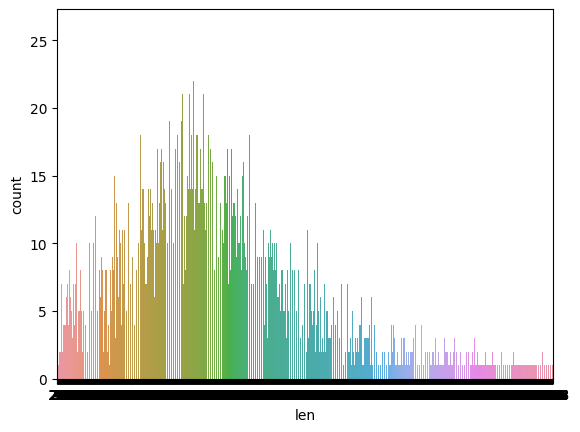

In [27]:

# count plot on single categorical variable
sns.countplot(x ='len', data = df)

# Show the plot
plt.show()


In [28]:
## dropping rows having context len less than 20

df = df.drop(df[df['len'] < 20].index)

In [29]:
df['len'].describe()

count    10578.000000
mean       629.003781
std        441.932427
min         21.000000
25%        368.250000
50%        551.000000
75%        771.000000
max       7493.000000
Name: len, dtype: float64

In [30]:
df

,index,question,answer,source,context,context_summary,len
0,0,extracting the top-k value-indices from a 1-d ...,as of pull request #496 torch now includes a b...,https://stackoverflow.com/questions/34750268/,Answer: as of pull request #496 torch now incl...,To extract the top-k value-indices from a 1-d ...,557
1,1,how to display custom images in tensorboard (e...,it is quite easy to do if you have the image i...,https://stackoverflow.com/questions/38543850/,Answer: it is quite easy to do if you have the...,Answer: use the gen_plot() function to create ...,994
2,2,python wheels: cp27mu not supported,this is exactly that. \nrecompile python under...,https://stackoverflow.com/questions/41767005/,Answer: this is exactly that. \nrecompile pyth...,"Answer: To fix the issue of the ""cp27mu not su...",671
3,3,loading torch7 trained models (.t7) in pytorch,as of pytorch 1.0 torch.utils.serialization is...,https://stackoverflow.com/questions/41861354/,Answer: as of pytorch 1.0 torch.utils.serializ...,Question: loading torch7 trained models (.t7) ...,696
4,4,pytorch: how to use dataloaders for custom dat...,"yes, that is possible. just create the objects...",https://stackoverflow.com/questions/41924453/,"Answer: yes, that is possible. just create the...",Question: How to use dataloaders for custom da...,1171
...,...,...,...,...,...,...,...
10573,10758,is it possible to perform quantization on dens...,here's how to do this on densenet169 from torc...,https://stackoverflow.com/questions/74612146/,Answer: here's how to do this on densenet169 f...,Answer: To perform quantization on densenet169...,1612
10574,10759,"why when the batch size increased, the epoch t...","as you already noticed, there are many factors...",https://stackoverflow.com/questions/74637151/,"Answer: as you already noticed, there are many...",Q: Why does increasing the batch size increase...,913
10575,10760,why does stablediffusionpipeline return black ...,apparently it is indeed an apple silicon (m1/m...,https://stackoverflow.com/questions/74642594/,Answer: apparently it is indeed an apple silic...,Answer: The stablediffusionpipeline returns bl...,621
10576,10761,locating tags in a string in php (with respect...,i think i've got something. how about this:\nf...,https://stackoverflow.com/questions/74671399/,Answer: i think i've got something. how about ...,Answer: You can use the function label_italics...,526


In [31]:
df.to_csv('so_context_with_summary.csv')

## create faiss index to use this during query time

In [20]:
def split_pages(df):
    splitter = CharacterTextSplitter(separator="\n", chunk_size=2048)
    print('chunking pages into smaller sub-pages')
            
    pages = []

    for index, i in df.iterrows():
        texts = "context: " + i['context_summary']
        meta = {'source':i['source']}
        pages.extend(splitter.create_documents([texts], [meta]))
    pickle.dump(pages, open('so_context_summary_pages.pkl', 'wb'))

split_pages(df)



pages = pickle.load(open('so_context_summary_pages.pkl', 'rb'))

docsearch = FAISS.from_documents([pages.pop(0)], embeddings)
i, step = 0, 50
while i<len(pages):
    if i%500==0:
        print(i,'pages done')
    texts = [d.page_content for d in pages[i:i+step]]
    meta = [d.metadata for d in pages[i:i+step]]
    docsearch.add_texts(texts, meta)
    i += step
print(len(pages),'pages done')

chunking pages into smaller sub-pages
0 pages done
500 pages done
1000 pages done
1500 pages done
2000 pages done
2500 pages done
3000 pages done
3500 pages done
4000 pages done
4500 pages done
5000 pages done
5500 pages done
6000 pages done
6500 pages done
7000 pages done
7500 pages done
8000 pages done
8500 pages done
9000 pages done
9500 pages done
10000 pages done
10500 pages done
10744 pages done


In [22]:
docsearch.save_local('so_context_summary_faiss_index')

## preparing alpaca lora dataset format

In [20]:
data = []

for index, row in df.iterrows():
    d = { "instruction": row['question'][0:1024],
          "input": row['context_summary'][0:1024],
          "output": row['answer'][0:2048]
        }
    
    data.append(d)
    

with open('so_context_with_summary.json', 'w') as f:
    json.dump(data, f)